# Plotting

### SF Diversity Project - plotting data, descriptive fits, and functional model fits

Last used:    11.13.2018

Last updated: 11.13.2018

Major update on 11.13.2018 - Copied plotting/analysis code from plotting.py script/functions

#### Pick your cell, fit types

In [8]:
cellNum = 2;
lossType = 3; # sqrt (1), poiss (2), modPoiss (3)
fitType = 2; # flat norm (1), tuned gauss weighting (2), or wrong c50 model (3)
log_y = 0; # linear y (0) or log y(1)

#### Set constants

In [26]:
import os
import sys
import numpy as np
from helper_fcns import organize_modResp, flexible_Gauss, getSuppressiveSFtuning, compute_SF_BW, genNormWeights, random_in_range, evalSigmaFilter, setSigmaFilter, np_smart_load
import model_responses as mod_resp
from itertools import chain
import matplotlib
matplotlib.use('Agg') # why? so that we can get around having no GUI on cluster                                                                                                                                                                                               
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf as pltSave
import seaborn as sns

save_loc = '/Users/paulgerald/work/sfDiversity/sfDiv-OriModel/sfDiv-python/Analysis/Figures'; # local
data_loc = '/Users/paulgerald/work/sfDiversity/sfDiv-OriModel/sfDiv-python/Analysis/Structures/'; # local
# save_loc = '/ser/1.2/p2/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/Analysis/Figures/'; # CNS
# data_loc = '/ser/1.2/p2/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/Analysis/Structures/'; # CNS

/Users/paulgerald/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [7]:
# plotting style
plt.style.use('https://raw.githubusercontent.com/paul-levy/SF_diversity/master/Analysis/Functions/paul_plt_cluster.mplstyle');
sns.set(style='ticks');

# better plotting                                                                                                                                                                                                                                                             
from matplotlib import rcParams
rcParams['font.size'] = 20;
rcParams['pdf.fonttype'] = 42 # should be 42, but there are kerning issues                                                                                                                                                                                                    
rcParams['ps.fonttype'] = 42 # should be 42, but there are kerning issues                                                                                                                                                                                                     
rcParams['lines.linewidth'] = 2.5;
rcParams['axes.linewidth'] = 1.5;
rcParams['lines.markersize'] = 5;
rcParams['font.style'] = 'oblique';
rcParams['legend.fontsize'] ='large'; # using a named size                                        

#### Load files

In [10]:
expName = 'dataList.npy'
fitBase = 'fitList_180713';
# first the fit type                                                                                                                                                                                                                                                          
if fitType == 1:
    fitSuf = '_flat';
elif fitType == 2:
    fitSuf = '_wght';
elif fitType == 3:
    fitSuf = '_c50';
# then the loss type                                                                                                                                                                                                                                                          
if lossType == 1:
    lossSuf = '_sqrt.npy';
elif lossType == 2:
    lossSuf = '_poiss.npy';
elif lossType == 3:
    lossSuf = '_modPoiss.npy';

fitName = str(fitBase + fitSuf + lossSuf);

descrExpName = 'descrFits.npy';
descrModName = 'descrFitsModel.npy';

In [11]:
nFam = 5;
nCon = 2;
plotSteps = 100; # how many steps for plotting descriptive functions?                                                                                                                                                                                                         
sfPlot = np.logspace(-1, 1, plotSteps);

# for bandwidth/prefSf descriptive stuff                                                                                                                                                                                                                                      
muLoc = 2; # mu is in location '2' of parameter arrays                                                                                                                                                                                                                        
height = 1/2.; # measure BW at half-height                                                                                                                                                                                                                                    
sf_range = [0.01, 10]; # allowed values of 'mu' for fits - see descr_fit.py for details                                                                                                                                                                                       

dL = np_smart_load(data_loc + expName);
fitList = np_smart_load(data_loc + fitName);
descrExpFits = np_smart_load(data_loc + descrExpName);
descrModFits = np_smart_load(data_loc + descrModName);

# #### Load data                                                                                                                                                                                                                                                              

expData = np_smart_load(str(data_loc + dL['unitName'][cellNum-1] + '_sfm.npy'));
expResp = expData
modFit = fitList[cellNum-1]['params']; #                                                                                                                                                                                                                                      
descrExpFit = descrExpFits[cellNum-1]['params']; # nFam x nCon x nDescrParams                                                                                                                                                                                                 
descrModFit = descrModFits[cellNum-1]['params']; # nFam x nCon x nDescrParams                                              

In [107]:
# fitSuf = '_flat'
# norm_type = 1
# fitType = 1

fitSuf = '_wght'
norm_type = 2
fitType = 2

In [108]:
# holdoutFits
hldName = 'hQ_%d_%s%s' % (cellNum, fitSuf, lossSuf)
hldFits = np_smart_load(data_loc + hldName);
hldParams = hldFits['params']

#### Analyze data

In [111]:
# enter a manual modFit, if desired
manDisp = 4;
manCon  = 0;
manSF   = 10;

modFit = hldParams[manDisp, manCon, manSF]

In [112]:
norm_type = fitType;
ignore, modResp = mod_resp.SFMGiveBof(modFit, expData, normType=norm_type, lossType=lossType);
if norm_type == 2:
    gs_mean = modFit[8];
    gs_std = modFit[9];
oriModResp, conModResp, sfmixModResp, allSfMix = organize_modResp(modResp, expData['sfm']['exp']['trial'])
oriExpResp, conExpResp, sfmixExpResp, allSfMixExp = organize_modResp(expData['sfm']['exp']['trial']['spikeCount'], \
                                                                           expData['sfm']['exp']['trial'])
#pdb.set_trace();                                                                                                                                                                                                                                                             

# allSfMix is (nFam, nCon, nCond, nReps) where nCond is 11, # of SF centers and nReps is usually 10                                                                                                                                                                           
modLow = np.nanmin(allSfMix, axis=3);
modHigh = np.nanmax(allSfMix, axis=3);
modAvg = np.nanmean(allSfMix, axis=3);
modSponRate = modFit[6];

findNan = np.isnan(allSfMixExp);
nonNan = np.sum(findNan == False, axis=3); # how many valid trials are there for each fam x con x center combination?                                                                                                                                                         
allExpSEM = np.nanstd(allSfMixExp, axis=3) / np.sqrt(nonNan); # SEM                                                                                                                                                                                                           

# Do some analysis of bandwidth, prefSf                                                                                                                                                                                                                                       

bwMod = np.ones((nFam, nCon)) * np.nan;
bwExp = np.ones((nFam, nCon)) * np.nan;
pSfMod = np.ones((nFam, nCon)) * np.nan;
pSfExp = np.ones((nFam, nCon)) * np.nan;

for f in range(nFam):

    ignore, bwMod[f,0] = compute_SF_BW(descrModFit[f, 0, :], height, sf_range)
    ignore, bwMod[f,1] = compute_SF_BW(descrModFit[f, 1, :], height, sf_range)
    pSfMod[f,0] = descrModFit[f, 0, muLoc]
    pSfMod[f,1] = descrModFit[f, 1, muLoc]

    ignore, bwExp[f, 0] = compute_SF_BW(descrExpFit[f, 0, :], height, sf_range)
    ignore, bwExp[f, 1] = compute_SF_BW(descrExpFit[f, 1, :], height, sf_range)
    pSfExp[f, 0] = descrExpFit[f, 0, muLoc]
    pSfExp[f, 1] = descrExpFit[f, 1, muLoc]


### Plot the main stuff - sfMix experiment with model predictions and descriptive fits

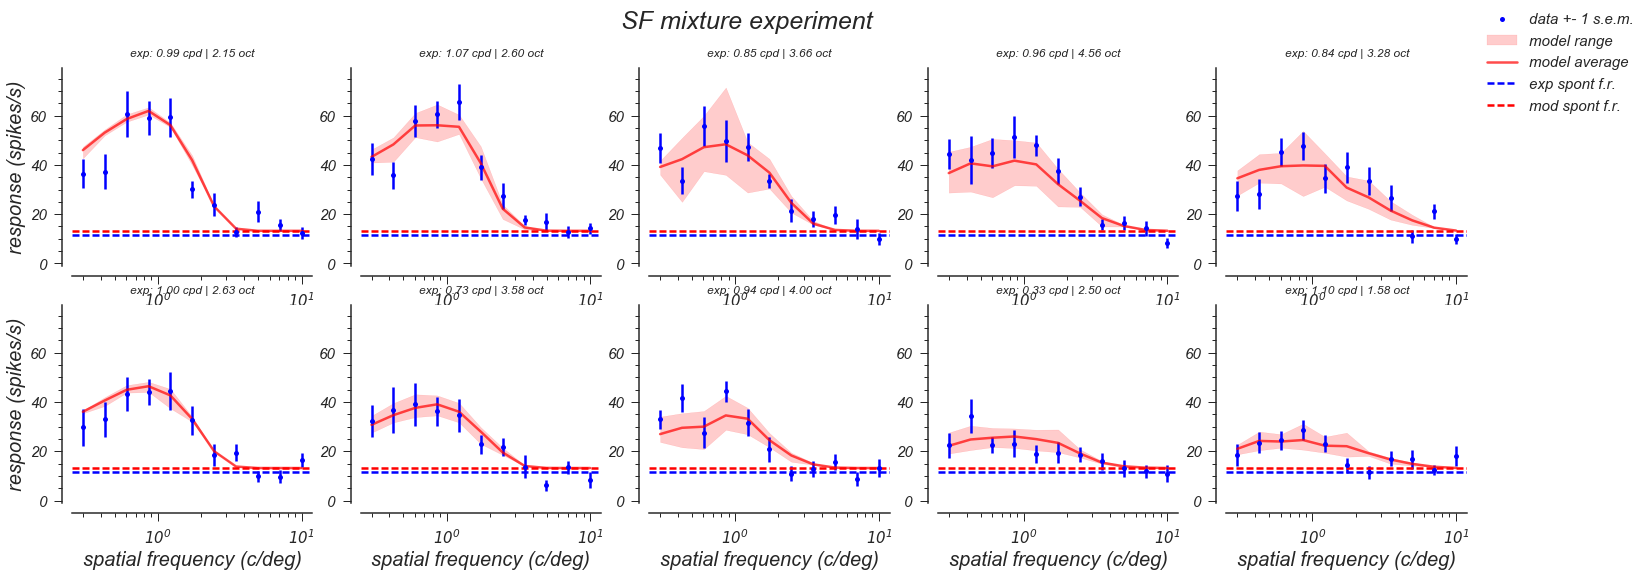

In [113]:
f, all_plots = plt.subplots(nCon, nFam, sharex=True, sharey=True, figsize=(25,8))
expSfCent = expData['sfm']['exp']['sf'][0][0];
expResponses = expData['sfm']['exp']['sfRateMean'];
# sfRateMean/Var are doubly-nested (i.e. [nFam][nCon][sf] rather than [nFam, nCon, sf]) unpack here                                                                                                                                                                           
sfMeanFlat = list(chain.from_iterable(chain.from_iterable(expResponses)));
sfVarFlat = list(chain.from_iterable(chain.from_iterable(expData['sfm']['exp']['sfRateVar'])));

# plot experiment and models                                                                                                                                                                                                                                                  
for con in reversed(range(nCon)): # contrast                                                                                                                                                                                                                                  
    yMax = 1.25*np.maximum(np.amax(expResponses[0][con]), np.amax(modHigh[0, con, :])); # we assume that 1.25x Max response for single grating will be enough                                                                                                                 
    all_plots[con, 0].set_ylim([-1, yMax]);
    for fam in reversed(range(nFam)): # family                                                                                                                                                                                                                                
        expPoints = all_plots[con, fam].errorbar(expSfCent, expResponses[fam][con], allExpSEM[fam, con, :],\
                                                 linestyle='None', marker='o', color='b', clip_on=False);
        modRange = all_plots[con, fam].fill_between(expSfCent, modLow[fam,con,:], \
                                                    modHigh[fam, con,:], color='r', alpha=0.2);
        modAvgPlt = all_plots[con, fam].plot(expSfCent, modAvg[fam, con,:], 'r-', alpha=0.7, clip_on=False);
        #modAvgPlt = all_plots[con, fam].plot(expSfCent, modAvg[fam, con,:], 'ro', alpha=0.2, clip_on=False);                                                                                                                                                                 
        sponRate = all_plots[con, fam].axhline(expData['sfm']['exp']['sponRateMean'], color='b', linestyle='dashed');
        sponRateMod = all_plots[con, fam].axhline(modSponRate, color='r', linestyle='dashed');
        all_plots[con,fam].set_xscale('log');
        if log_y:
            all_plots[con,fam].set_yscale('log');

        # pretty                                                                                                                                                                                                                                                              
        all_plots[con,fam].tick_params(labelsize=15, width=1, length=8, direction='out');
        all_plots[con,fam].tick_params(width=1, length=4, which='minor', direction='out'); # minor ticks, too...                                                                                                                                                              
        if con == 1:
            all_plots[con, fam].set_xlabel('spatial frequency (c/deg)', fontsize=20);
        if fam == 0:
            all_plots[con, fam].set_ylabel('response (spikes/s)', fontsize=20);

        #all_plots[con,fam].text(0.5,1.05, 'mod: {:.2f} cpd | {:.2f} oct'.format(pSfMod[fam, con], bwMod[fam, con]), fontsize=12, horizontalalignment='center', verticalalignment='top', transform=all_plots[con,fam].transAxes);                                             
        all_plots[con,fam].text(0.5,1.10, 'exp: {:.2f} cpd | {:.2f} oct'.format(pSfExp[fam, con], bwExp[fam, con]), fontsize=12, horizontalalignment='center', verticalalignment='top', transform=all_plots[con,fam].transAxes);

        # Remove top/right axis, put ticks only on bottom/left, despine                                                                                                                                                                                                       
        all_plots[con, fam].spines['right'].set_visible(False);
        all_plots[con, fam].spines['top'].set_visible(False);
        all_plots[con, fam].xaxis.set_ticks_position('bottom');
        all_plots[con, fam].yaxis.set_ticks_position('left');
        sns.despine(ax=all_plots[con, fam], offset = 10);


f.legend((expPoints[0], modRange, modAvgPlt[0], sponRate, sponRateMod), ('data +- 1 s.e.m.', 'model range', 'model average', 'exp spont f.r.', 'mod spont f.r.'), fontsize = 15, loc='upper right');
f.suptitle('SF mixture experiment', fontsize=25);

### Model components

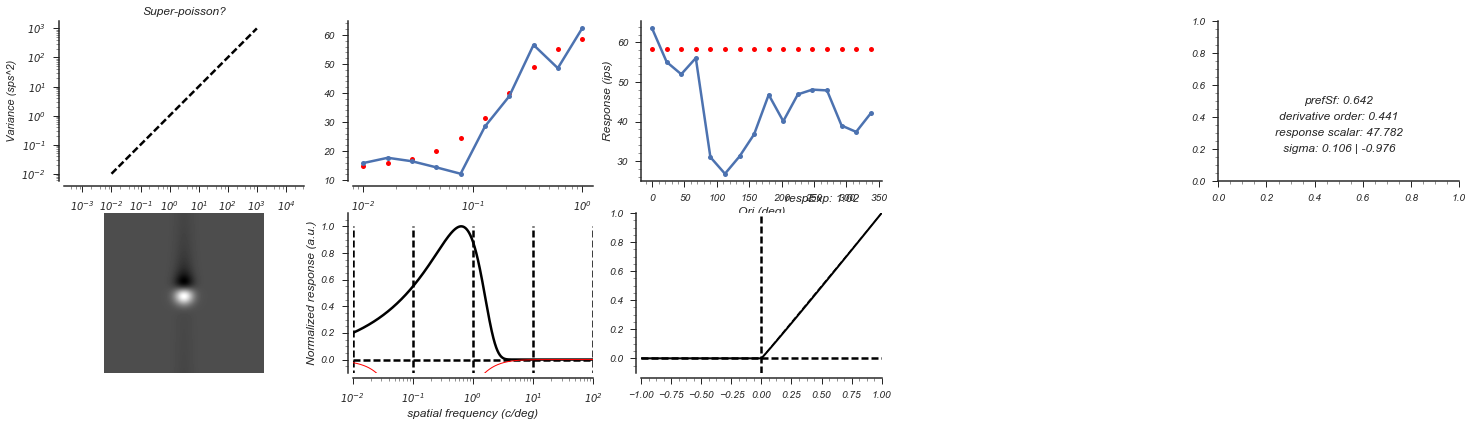

In [23]:
fDetails = plt.figure();
fDetails.set_size_inches(w=25, h=10);
detailSize = (3, 5);
# plot ori tuning                                                                                                                                                                                                                                                             
curr_ax = plt.subplot2grid(detailSize, (0, 2));
modPlt = plt.plot(expData['sfm']['exp']['ori'], oriModResp, 'ro', clip_on=False); # Model responses                                                                                                                                                                           
expPlt = plt.plot(expData['sfm']['exp']['ori'], expData['sfm']['exp']['oriRateMean'], 'o-', clip_on=False); # Exp responses                                                                                                                                                   
plt.xlabel('Ori (deg)', fontsize=12);
plt.ylabel('Response (ips)', fontsize=12);

# CRF - with values from TF simulation and the broken down (i.e. numerator, denominator separately) values from resimulated conditions                                                                                                                                        
curr_ax = plt.subplot2grid(detailSize, (0, 1)); # default size is 1x1                                                                                                                                                                                                         
consUse = expData['sfm']['exp']['con'];
base = np.amin(conModResp);
amp = np.amax(conModResp) - base;
plt.semilogx(consUse, conModResp, 'ro', clip_on=False); # Model responses                                                                                                                                                                                                     
plt.semilogx(consUse, expData['sfm']['exp']['conRateMean'], 'o-', clip_on=False); # Measured responses                                                                                                                                                                        
crf = lambda con, base, amp, sig, rExp: base + amp*np.power((con / np.sqrt(np.power(sig, 2) + np.power(con, 2))), rExp);
#plt.semilogx(consUse, crf(consUse, base, amp, np.power(10, modFit[2]), modFit[3]), '--');                                                                                                                                                                                    
plt.xlabel('Con (%)', fontsize=20);
# Remove top/right axis, put ticks only on bottom/left                                                                                                                                                                                                                        
sns.despine(ax=curr_ax, offset = 5);

#poisson test - mean/var for each condition (i.e. sfXdispXcon)                                                                                                                                                                                                                
curr_ax = plt.subplot2grid(detailSize, (0, 0));
lower_bound = 1e-2;
plt.loglog([lower_bound, 1000], [lower_bound, 1000], 'k--');
meanList = (expData['sfm']['exp']['conRateMean'], expData['sfm']['exp']['oriRateMean'], sfMeanFlat);
varList = (expData['sfm']['exp']['conRateVar'], expData['sfm']['exp']['oriRateVar'], sfVarFlat);
for i in range(len(meanList)):
    gtLB = np.logical_and(np.array(meanList[i])>lower_bound, np.array(varList[i])>lower_bound);
    #plt.loglog(meanList[i][gtLB], varList[i][gtLB], 'o');                                                                                                                                                                                                                      
# skeleton for plotting modulated poisson prediction                                                                                                                                                                                                                          
if fitType == 3: # i.e. modPoiss                                                                                                                                                                                                                                              
    varGain = modFit[7];
    mean_vals = np.logspace(-1, 2, 50);
    plt.loglog(mean_vals, mean_vals + varGain*np.square(mean_vals));

plt.xlabel('Mean (sps)');
plt.ylabel('Variance (sps^2)');
plt.title('Super-poisson?');
plt.axis('equal');
sns.despine(ax=curr_ax, offset=5, trim=False);

# plot model details - filter                                                                                                                                                                                                                                                 
curr_ax = plt.subplot2grid(detailSize, (1, 0));
imSizeDeg = expData['sfm']['exp']['size'];
pixSize   = 0.0028; # fixed from Robbe                                                                                                                                                                                                                                        
prefSf    = modFit[0];
dOrder    = modFit[1]
prefOri = 0; # just fixed value since no model param for this                                                                                                                                                                                                                 
aRatio = 1; # just fixed value since no model param for this                                                                                                                                                                                                                  
filtTemp  = mod_resp.oriFilt(imSizeDeg, pixSize, prefSf, prefOri, dOrder, aRatio);
filt      = (filtTemp - filtTemp[0,0])/ np.amax(np.abs(filtTemp - filtTemp[0,0]));
plt.imshow(filt, cmap='gray');
plt.axis('off');

# plot model details - exc/suppressive components                                                                                                                                                                                                                             
omega = np.logspace(-2, 2, 1000);
sfRel = omega/prefSf;
s     = np.power(omega, dOrder) * np.exp(-dOrder/2 * np.square(sfRel));
sMax  = np.power(prefSf, dOrder) * np.exp(-dOrder/2);
sfExc = s/sMax;

inhSfTuning = getSuppressiveSFtuning();
# Compute weights for suppressive signals                                                                                                                                                                                                                                     
nInhChan = expData['sfm']['mod']['normalization']['pref']['sf'];
if norm_type == 2:
    nTrials =  inhSfTuning.shape[0];
    inhWeight = genNormWeights(expData, nInhChan, gs_mean, gs_std, nTrials);
    inhWeight = inhWeight[:, :, 0]; # genNormWeights gives us weights as nTr x nFilters x nFrames - we have only one "frame" here, and all are the same                                                                                                                         
else:
    if len(modFit) == 9: # i.e. if right number of model parameters...                                                                                                                                                                                                          
        inhAsym = modFit[8];
    else:
        inhAsym = 0;

    inhWeight = [];
    for iP in range(len(nInhChan)):
        inhWeight = np.append(inhWeight, 1 + inhAsym * (np.log(expData['sfm']['mod']['normalization']['pref']['sf'][iP]) - np.mean(np.log(expData['sfm']['mod']['normalization']['pref']['sf'][iP]))));

sfNorm = np.sum(-.5*(inhWeight*np.square(inhSfTuning)), 1);
sfNorm = sfNorm/np.amax(np.abs(sfNorm));

# just setting up lines                                                                                                                                                                                                                                                       
curr_ax = plt.subplot2grid(detailSize, (1, 1));
plt.semilogx([omega[0], omega[-1]], [0, 0], 'k--')
plt.semilogx([.01, .01], [-1.5, 1], 'k--')
plt.semilogx([.1, .1], [-1.5, 1], 'k--')
plt.semilogx([1, 1], [-1.5, 1], 'k--')
plt.semilogx([10, 10], [-1.5, 1], 'k--')
plt.semilogx([100, 100], [-1.5, 1], 'k--')
# now the real stuff                                                                                                                                                                                                                                                          
plt.semilogx(omega, sfExc, 'k-')
#plt.semilogx(omega, sfInh, 'r--', linewidth=2);                                                                                                                                                                                                                              
plt.semilogx(omega, sfNorm, 'r-', linewidth=1);
plt.xlim([omega[0], omega[-1]]);
plt.ylim([-0.1, 1.1]);
plt.xlabel('spatial frequency (c/deg)', fontsize=12);
plt.ylabel('Normalized response (a.u.)', fontsize=12);
# Remove top/right axis, put ticks only on bottom/left                                                                                                                                                                                                                        
sns.despine(ax=curr_ax, offset=5);

# last but not least...and not last... response nonlinearity                                                                                                                                                                                                                  
curr_ax = plt.subplot2grid(detailSize, (1, 2));
plt.plot([-1, 1], [0, 0], 'k--')
plt.plot([0, 0], [-.1, 1], 'k--')
plt.plot(np.linspace(-1,1,100), np.power(np.maximum(0, np.linspace(-1,1,100)), modFit[3]), 'k-', linewidth=2)
plt.plot(np.linspace(-1,1,100), np.maximum(0, np.linspace(-1,1,100)), 'k--', linewidth=1)
plt.xlim([-1, 1]);
plt.ylim([-.1, 1]);
plt.text(0.5, 1.1, 'respExp: {:.2f}'.format(modFit[3]), fontsize=12, horizontalalignment='center', verticalalignment='center');
# Remove top/right axis, put ticks only on bottom/left                                                                                                                                                                                                                        
sns.despine(ax=curr_ax, offset=5);

if norm_type == 3: # plot the c50 filter (i.e. effective c50 as function of SF)                                                                                                                                                                                               
    stimSf = np.logspace(-2, 2, 101);
    filtPeak = modFit[11];
    stdLeft = modFit[9];
    stdRight = modFit[10];

    filter = setSigmaFilter(filtPeak, stdLeft, stdRight);
    offset_filt = modFit[8];
    scale_filt = -(1-offset_filt); # we always scale so that range is [offset_sf, 1]                                                                                                                                                                                            
    c50_filt = evalSigmaFilter(filter, scale_filt, offset_filt, stimSf)

    # now plot                                                                                                                                                                                                                                                                  
    curr_ax = plt.subplot2grid(detailSize, (2, 4));
    plt.semilogx(stimSf, c50_filt);
    plt.title('(mu, stdL/R, offset) = (%.2f, %.2f|%.2f, %.2f)' % (filtPeak, stdLeft, stdRight, offset_filt));
    plt.xlabel('spatial frequency (c/deg)');
    plt.ylabel('c50 (con %)')

# actually last - CRF at different dispersion levels                                                                                                                                                                                                                          
crf_row = len(all_plots)-1; # we're putting the CRFs in the last row of this plot                                                                                                                                                                                             
crf_sfIndex = np.argmin(abs(expSfCent - descrExpFit[0][0][2])); # get mu (i.e. prefSf) as measured at high contrast, single grating and find closest presented SF (index)                                                                                                     
crf_sfVal = expSfCent[crf_sfIndex]; # what's the closest SF to the pref that was presented?                                                                                                                                                                                   
crf_cons = expData['sfm']['exp']['con']; # what contrasts to sim. from model? Same ones used in exp                                                                                                                                                                           
crf_sim = np.zeros((nFam, len(crf_cons))); # create nparray for results            

# first, run the CRFs...                                                                                                                                                                                                                                                      
'''                                                                                                                                                                                                                                                                           
for i in range(nFam):                                                                                                                                                                                                                                                         
    print('simulating CRF for family ' + str(i+1));                                                                                                                                                                                                                           
    for j in range(len(crf_cons)):                                                                                                                                                                                                                                            
        simResp, ignore, ignore = mod_resp.SFMsimulate(modFit, expData, i+1, crf_cons[j], crf_sfVal);                                                                                                                                                                         
        crf_sim[i, j] = np.mean(simResp); # take mean of the returned simulations (10 repetitions per stim. condition)                                                                                                                                                        
                                                                                                                                                                                                                                                                              
# now plot!                                                                                                                                                                                                                                                                   
for i in range(len(all_plots[0])):                                                                                                                                                                                                                                            
    curr_ax = plt.subplot2grid(detailSize, (crf_row, i));                                                                                                                                                                                                                     
    plt.semilogx(1, expResponses[i][0][crf_sfIndex], 'bo', clip_on=False); # exp response - high con                                                                                                                                                                          
    plt.semilogx(0.33, expResponses[i][1][crf_sfIndex], 'bo', clip_on=False); # exp response - low con                                                                                                                                                                        
    plt.semilogx(crf_cons, crf_sim[i, :], 'ro-', clip_on=False); # model resposes - range of cons                                                                                                                                                                             
    plt.xlabel('Con (%)', fontsize=20);                                                                                                                                                                                                                                       
    plt.xlim([1e-2, 1e0]);                                                                                                                                                                                                                                                    
    #plt.ylim([0, 1.05*np.amax(np.maximum(crf_sim[0, :], expResponses[0][0][crf_sfIndex]))]);                                                                                                                                                                                 
    if i == 0:                                                                                                                                                                                                                                                                
      plt.ylabel('Resp. amp (sps)');                                                                                                                                                                                                                                          
                                                                                                                                                                                                                                                                              
    # Remove top/right axis, put ticks only on bottom/left                                                                                                                                                                                                                    
    sns.despine(ax=curr_ax, offset=5);                                                                                                                                                                                                                                        
                                                                                                                                                                                                                                                                              
fDetails.legend((modPlt[0], expPlt[0]), ('model', 'experiment'), fontsize = 15, loc='center left');                                                                                                                                                                           
fDetails.suptitle('SF mixture - details', fontsize=25);                                                                                                                                                                                                                       
'''


# print, in text, model parameters:                                                                                                                                                                                                                                           
curr_ax = plt.subplot2grid(detailSize, (0, 4));
plt.text(0.5, 0.5, 'prefSf: {:.3f}'.format(modFit[0]), fontsize=12, horizontalalignment='center', verticalalignment='center');
plt.text(0.5, 0.4, 'derivative order: {:.3f}'.format(modFit[1]), fontsize=12, horizontalalignment='center', verticalalignment='center');
plt.text(0.5, 0.3, 'response scalar: {:.3f}'.format(modFit[4]), fontsize=12, horizontalalignment='center', verticalalignment='center');
plt.text(0.5, 0.2, 'sigma: {:.3f} | {:.3f}'.format(np.power(10, modFit[2]), modFit[2]), fontsize=12, horizontalalignment='center', verticalalignment='center');
if fitType == 3:
    plt.text(0.5, 0.1, 'varGain: {:.3f}'.format(varGain), fontsize=12, horizontalalignment='center', verticalalignment='center');
#plt.text(0.5, 0.1, 'inhibitory asymmetry: {:.3f}'.format(modFit[8]), fontsize=12, horizontalalignment='center', verticalalignment='center');    